# En este proyecto intentaremos predecir el género de una película dado el plot en inglés de la misma, asumiremos que las películas pertenecen a un único género

### Carga de datos y limpieza general

Comenzamos importando las librerias

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from IPython.display import display
from wordcloud import WordCloud
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn import preprocessing
from sklearn.utils import shuffle

Descargamos el dataset de Kaggle de este link: https://www.kaggle.com/jrobischon/wikipedia-movie-plots ... Adicionalmente, revisaremos brevemente la información que contiene el DataSet

In [2]:
df = pd.read_csv('wiki_movie_plots_deduped.csv')

In [3]:
display(df.head(2))
display(df.shape)
display(df["Genre"].value_counts().head(10))
display("Unique genres values: {}".format(len(df["Genre"].value_counts())))

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."


(34886, 8)

unknown      6083
drama        5964
comedy       4379
horror       1167
action       1098
thriller      966
romance       923
western       865
crime         568
adventure     526
Name: Genre, dtype: int64

'Unique genres values: 2265'

Me quedo únicamente con los 4 géneros que voy a utilizar para clasificar: "Comedy","Action","Horror" and "Drama

In [4]:
categorias = ["comedy","action","horror","drama"]
movies = df[df["Genre"].isin(categorias)][["Genre","Plot"]]

### Análisis sobre los géneros

In [5]:
# Vemos la cantidad de películas que hay por género
gen_values = movies["Genre"].value_counts()
gen_values

drama     5964
comedy    4379
horror    1167
action    1098
Name: Genre, dtype: int64

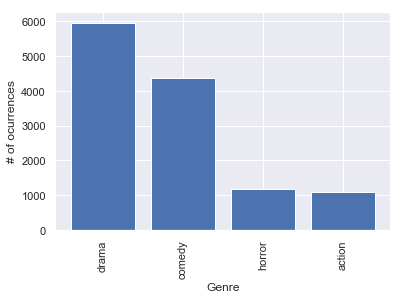

In [6]:
# Creamos un gráfico visual
sns.set()
_ = plt.bar(gen_values.index,gen_values.values)
plt.xticks(rotation=90)
plt.xlabel("Genre")
plt.ylabel('# of ocurrences')
plt.show()

Nos quedamos con la misma cantidad de películas por género. La cantidad la defenirá el género que tenga menor películas. (Acción en este caso)

In [7]:
max_cantidad = gen_values.min()
new_movies = pd.DataFrame()

for genre in categorias:
    filtrado_por_genero = movies[movies["Genre"]==genre]
    genero = (filtrado_por_genero.sample(min(len(filtrado_por_genero),int(max_cantidad))))
    new_movies = new_movies.append(genero)



In [8]:
# Vemos que ahora la cantidad de películas por géneros es la misma.
pd.DataFrame(new_movies["Genre"].value_counts())

,Genre
drama,1098
horror,1098
action,1098
comedy,1098


Convirtamos a valores numéricos los géneros de las películas. Esto lo hacemos para preparar la información para el momento de la clasificación, ya que los algoritmos no entienden de palabras si no de valores numéricos.

In [9]:
le = preprocessing.LabelEncoder()
labels = le.fit_transform(new_movies["Genre"])
new_movies["Genres_Label"] = labels
movies_cleaned = new_movies[["Plot","Genres_Label"]]

In [10]:
# Mezclamos un poco los datos para que no esten ordenados al momento de aplicar el clasificador
movies_cleaned = shuffle(movies_cleaned)
movies_cleaned.head()

,Plot,Genres_Label
11387,"On Christmas Eve, two years after the Nakatomi...",0
16910,Forty years after the events of the first film...,3
9962,"On October 23, shop owner Harry Grimbridge run...",3
10954,The film starts with a group of kids taking a ...,3
13262,Birdee Pruitt (Sandra Bullock) is a Chicago ho...,2


### Limpieza de los plots

Comenzamos por crear una serie de funciones que nos permitirán limpiar los plots. Stem nos deja con la raiz de las palabras, lemmatize convierte palabras similares en la misma, el resto de las funciones simplemente eliminan palabras comunes y valores que no sean letras. Finalmente, preprocessing 2 se queda con las palabras que más veces aparezcan repetidas. 

In [11]:
stop_words = stopwords.words("english")
Stop_word_TryAndError = ["ha","wa","one","get","take","go","back","tell","two","make","see","come","hi","tri","him",'thi',"onli","him","also","later"]
lemma=WordNetLemmatizer()
token=ToktokTokenizer()
stemmer = PorterStemmer()

In [21]:
def lemitizeWords(text):
    listLemma = []
    words=token.tokenize(text)
    stem = [stemmer.stem(word) for word in words]
    for w in stem:
        x=lemma.lemmatize(w)
        listLemma.append(x)
    return listLemma

def stopWordsRemove(text):
    wordList =[x.lower().strip() for x in token.tokenize(text)]
    removedList=[x for x in wordList if x not in stop_words and x not in Stop_word_TryAndError]
    text=" ".join(removedList)
    return text

def removeCharDigit(text):
    str="1234567890-=~@#$%^&*()_+[!{;”:\’><.,/?”}]"
    for w in text:
        if w in str:
            text=text.replace(w,"")
    return text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

def PreProcessing(text):
    text = lemitizeWords(text)
    text = stopWordsRemove(text)
    text = clean_text(text)
    text = removeCharDigit(text)   
    return(text)

def preprocessing2(x):
    alo = nltk.FreqDist([word for word in x.split()]).most_common(120)
    return " ".join([ word[0] for word in alo])

In [22]:
ejemplo = " ".join(movies_cleaned[["Plot"]].iloc[2].tolist())
print("Por ejemplo, la frase: {}".format(ejemplo))
print("\nSe convierte en:")
print("\n{}".format(preprocessing2(PreProcessing(ejemplo))))

Por ejemplo, la frase: On October 23, shop owner Harry Grimbridge runs along a barren road in Northern California, chased by mysterious figures in business suits. He makes it to a gas station, clutching a jack-o'-lantern mask. He is driven to the hospital by station attendant Walter Jones. At the hospital, Grimbridge is placed in the care of Dr. Dan Challis. That night, another mysterious man in a suit enters Grimbridge's hospital room, kills him, then goes to his car and immolates himself.
The next morning, Grimbridge's daughter, Ellie, arrives to identify her father's remains. Ellie and Challis agree to investigate his murder, leading them to the small town of Santa Mira, California. The motel manager explains that Conal Cochran and his company, Silver Shamrock Novelties, which produces wildly popular latex jack-o-lantern, witch and skeleton masks for Halloween, are responsible for the town's prosperity. While signing the motel register, Challis learns that Grimbridge stayed at the s

In [23]:
# Apliquemos la funcion a todos los plots. 
movies_cleaned["plot_cleaned"] = movies_cleaned["Plot"].apply(lambda x : PreProcessing(x)).apply(lambda x: preprocessing2(x))

### Análisis de las palabras de los plots 

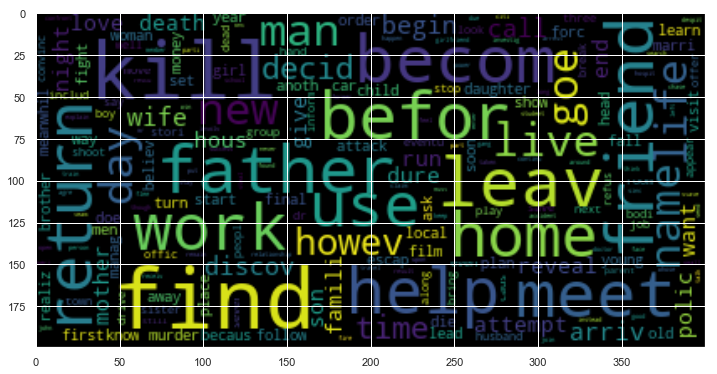

In [24]:
totalText=""
for words in movies_cleaned["plot_cleaned"]:
    totalText += words

wc=WordCloud(background_color="black",max_font_size=50).generate(totalText)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")

### Frecuencia con la que aparecen las palabras 

Text(0.5, 1.0, 'Most frequent Words')

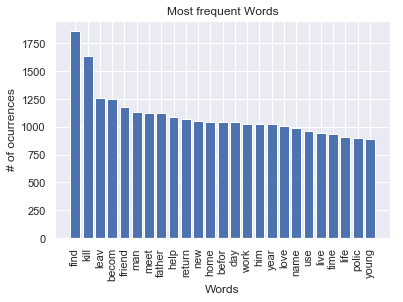

In [25]:
x=nltk.FreqDist(ToktokTokenizer().tokenize(totalText)).most_common(25)
words = [words[0] for words in x]
values = [values[1] for values in x]

_= plt.bar(words,values)
_ = plt.xticks(rotation=90)
plt.xlabel("Words")
plt.ylabel("# of ocurrences")
plt.title("Most frequent Words")

Modifiquemos las palabras con one hot encoding, para ello utilizamos CountVectorier y TfidfTransformer

In [26]:
encode = movies_cleaned.loc[:,"plot_cleaned"]
cv= CountVectorizer().fit(encode)
count_vect = pd.DataFrame(cv.transform(encode).todense(),columns=cv.get_feature_names())
tfidfhead=TfidfTransformer().fit(count_vect)
transformed =pd.DataFrame(tfidfhead.transform(count_vect).todense(),columns=cv.get_feature_names())

### Clasificacion - Entrenamiento y prueba de modelos 

In [27]:
X = transformed
y = movies_cleaned["Genres_Label"]

#### Random Forrest with GridSearch and 5 CVF. 

In [39]:
# Random Forest Classifier 
param_grid = {"n_estimators" : [50,80]}
rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf,param_grid,cv=5)
rf_cv.fit(X,y)
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'n_estimators': 80}
0.6607468123861566


#### Probamos con 3 modelos a ver los resultados. 

In [28]:
Linear_SVC = LinearSVC()
Logistic_Regression = LogisticRegression()
Gaussian_NB = GaussianNB()
clasificadores = {"Linear_SVC":Linear_SVC,"Logistic_Regression":Logistic_Regression,"Gaussian_NB":Gaussian_NB}

for k,v in clasificadores.items():
    cv_results = cross_val_score(v,X,y,cv=5)
    print('Clasificador: {}, Accuracy:{}'.format(k,np.mean(cv_results)))

Clasificador: Linear_SVC, Accuracy:0.7465836446658364
Clasificador: Logistic_Regression, Accuracy:0.750912204234122
Clasificador: Gaussian_NB, Accuracy:0.5721793275217932


#### Utilizamos LogisticRegression para generar la ConfusionMatrix

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test,y_pred)

In [30]:
def confusionMatrixHeatmap(cm, labels):
    totals = cm.sum(axis=1)
    cm_total = (np.ones(cm.shape)*totals).transpose()
    m2 = np.round(((cm/cm_total)*100).astype(float))
    np.set_printoptions(precision=2)
    f, ax=plt.subplots(figsize=(7.5,5))
    sns.heatmap(m2, annot=True, linecolor='white', linewidths=0.2,
                xticklabels=labels, yticklabels=labels)
    ax.set_title('CONFUSION MATRIX')
    plt.xlabel('Classified as')
    plt.ylabel('Real Values')

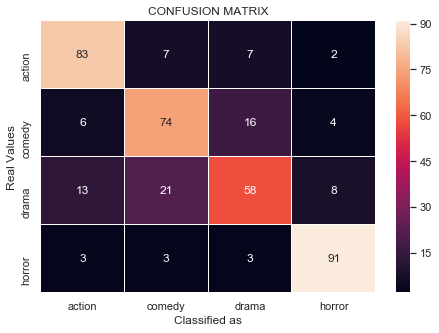

In [31]:
labels_mov = le.inverse_transform(list(set(labels))).tolist()
conf_matrix = confusionMatrixHeatmap(cm,labels_mov)
conf_matrix

Probamos 4 peliculas para ver lo que predice el modelo. 

In [32]:
# Book Club 
comedia = "Four longtime friends and book club members Diane Keaton, Jane Fonda, Candice Bergen and Mary Steenburgen have their lives upended when they aim to spice up their mundane routines by reading the provocative bestseller Fifty Shades of Grey. With newfound confidence, they each begin to come alive as exciting romances are ignited and old flames are rekindled. Through it all, the ladies inspire one other to make this next stage of their lives the best and steamiest thus far."

# Den of Thieves  
crimen = "A gritty crime saga which follows the lives of an elite unit of the LA County Sheriff's Dept. and the state's most successful bank robbery crew as the outlaws plan a seemingly impossible heist on the Federal Reserve Bank."

# Hereditary - El legado del diablo
horror = "After the family matriarch passes away, a grieving family is haunted by tragic and disturbing occurrences, and begin to unravel dark secrets."

# A Star is Born
drama = "A musician helps a young singer find fame, even as age and alcoholism send his own career into a downward spiral."



In [33]:
def conv_pelicula(x): 
    res = preprocessing2(PreProcessing(x))
    palabras = np.array(X.columns)
    vacia = []
    for palabra in palabras:
        if palabra in res:
            vacia.append(1)
        else:
            vacia.append(0)
    vacia = np.array(vacia)
    formato = vacia.reshape(1,-1)
    clf = LogisticRegression().fit(X,y)
    return pd.DataFrame(clf.predict_proba(formato),columns=le.inverse_transform(list(set(labels))))

In [34]:
conv_pelicula(comedia)

,action,comedy,drama,horror
0,0.000037,0.949968,0.012081,0.037914


In [35]:
conv_pelicula(crimen)

,action,comedy,drama,horror
0,0.688805,0.214534,0.007997,0.088663


In [36]:
conv_pelicula(horror)

,action,comedy,drama,horror
0,0.00856,0.000113,0.229856,0.761472


In [37]:
conv_pelicula(drama)

,action,comedy,drama,horror
0,0.030543,0.124283,0.839994,0.00518
